In [595]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
%matplotlib inline

In [596]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':5,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'correlation':0.2
        }

now = datetime.now()

Data Prep

In [597]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [598]:
df = pd.read_excel('wide_range.xlsx')

In [599]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

Feature Selection

In [600]:
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]

    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] >= args['correlation']:
            features.append(index)
        
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')


Features for Layer 1 (19):
 [3.95e-06, 4e-06, 3.9e-06, 4.05e-06, 3.85e-06, 3.8e-06, 4.1e-06, 3.75e-06, 4.15e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 2 (19):
 [4.05e-06, 4e-06, 4.1e-06, 3.85e-06, 3.9e-06, 3.95e-06, 3.8e-06, 4.15e-06, 3.75e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 3 (20):
 [4.2e-06, 4.15e-06, 4.25e-06, 3.75e-06, 4.1e-06, 3.8e-06, 4.3e-06, 4.05e-06, 3.85e-06, 3.9e-06, 4e-06, 4.55e-06, 3.95e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06, 4.7e-06]

Features for Layer 4 (20):
 [4.6e-06, 4.55e-06, 4.5e-06, 4.3e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.25e-06, 4.65e-06, 4.2e-06, 4.15e-06, 3.75e-06, 4.7e-06, 4.1e-06, 3.8e-06, 3.85e-06, 4.05e-06, 3.9e-06, 4e-06, 3.95e-06]

Features for Layer 5 (21):
 [4.6e-06, 4.5e-06, 4.55e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.3e-06, 4.65e-06, 4.25e-06, 4.2e-06, 4.7e-06, 4.15e-06, 3.7

In [601]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X_noisy = X + noise

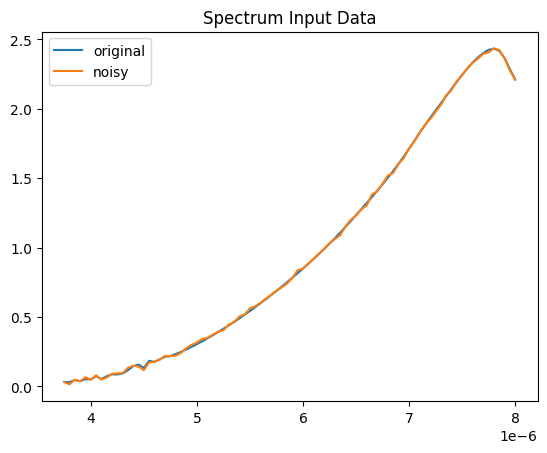

In [602]:
plt.title('Spectrum Input Data')
plt.plot(X.iloc[0], label='original')
plt.plot(X_noisy.iloc[0], label='noisy')
plt.legend()
plt.show()

In [603]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, train_size=args['train size'], random_state=101)

In [604]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [605]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [606]:
criterion = args['train criterion']

In [607]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [19, 15, 12, 9, 6, 3]
epoch: 50, loss = 21.719680786132812
epoch: 100, loss = 10.646919250488281
epoch: 150, loss = 10.220602035522461
epoch: 200, loss = 10.073630332946777
epoch: 250, loss = 10.028658866882324
epoch: 300, loss = 9.995375633239746
epoch: 350, loss = 9.971549034118652
epoch: 400, loss = 9.961129188537598
epoch: 450, loss = 9.953323364257812
epoch: 500, loss = 9.948201179504395
best loss: 9.948201179504395 in epoch 500

layer 2
hidden layer sizes: [19, 15, 12, 9, 6, 3]
epoch: 50, loss = 13.290102005004883
epoch: 100, loss = 11.09599494934082
epoch: 150, loss = 10.78952407836914
epoch: 200, loss = 10.70766830444336
epoch: 250, loss = 10.578086853027344
epoch: 300, loss = 10.538198471069336
epoch: 350, loss = 10.487858772277832
epoch: 400, loss = 10.455177307128906
epoch: 450, loss = 10.405993461608887
epoch: 500, loss = 10.365811347961426
best loss: 10.365811347961426 in epoch 500

layer 3
hidden layer sizes: [20, 16, 13, 10, 6, 3]
epoch: 50, l

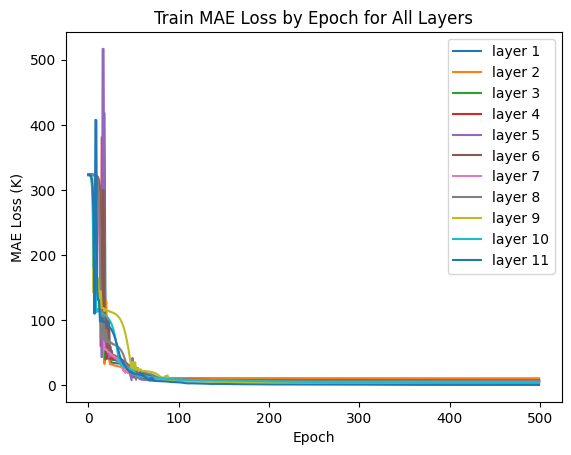

In [608]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [609]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 10.040572166442871
layer 2 loss: 10.436718940734863
layer 3 loss: 6.88621187210083
layer 4 loss: 7.291681289672852
layer 5 loss: 6.214608669281006
layer 6 loss: 6.668022155761719
layer 7 loss: 6.395709991455078
layer 8 loss: 6.305983066558838
layer 9 loss: 4.457427024841309
layer 10 loss: 3.512463331222534
layer 11 loss: 0.49085426330566406


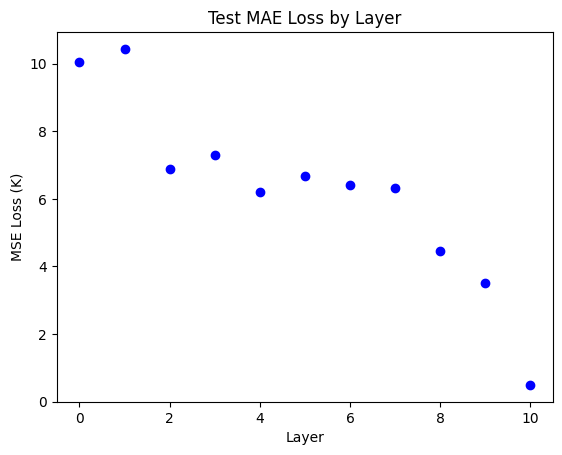

In [610]:
plt.plot(test_losses, 'bo')

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [611]:
def plot_comparison(pred, actual):
    plt.figure(figsize=(15, 5))
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [612]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

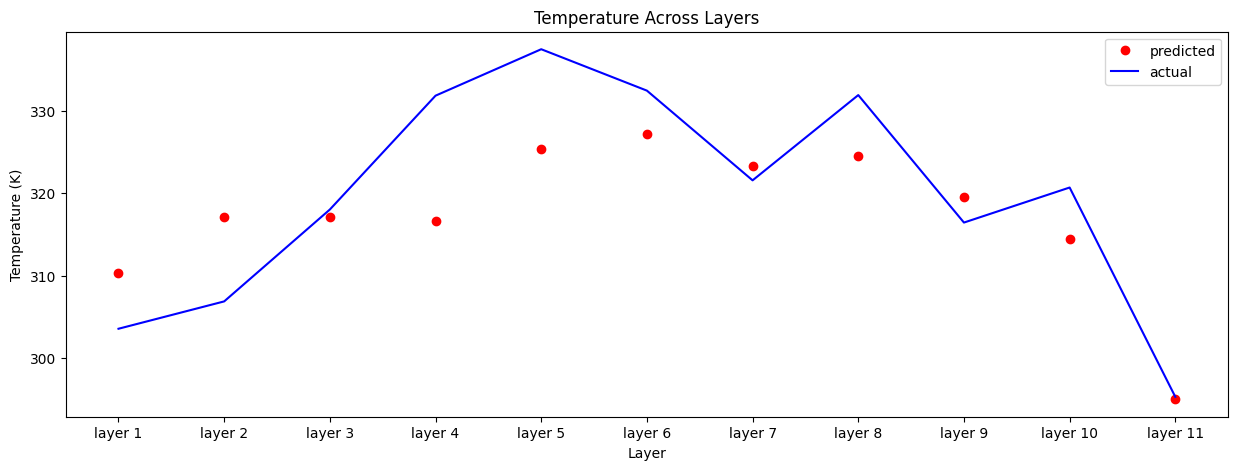

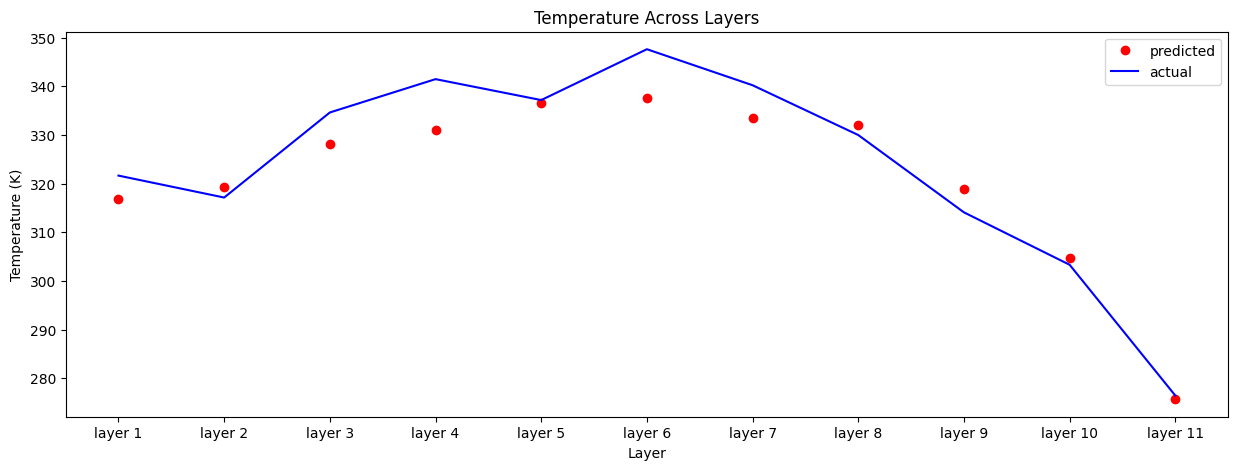

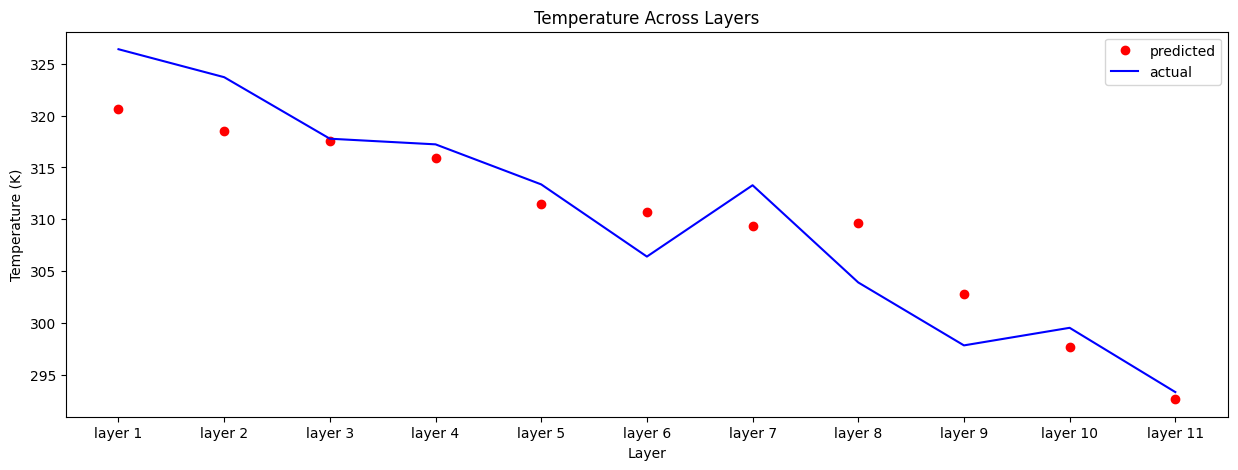

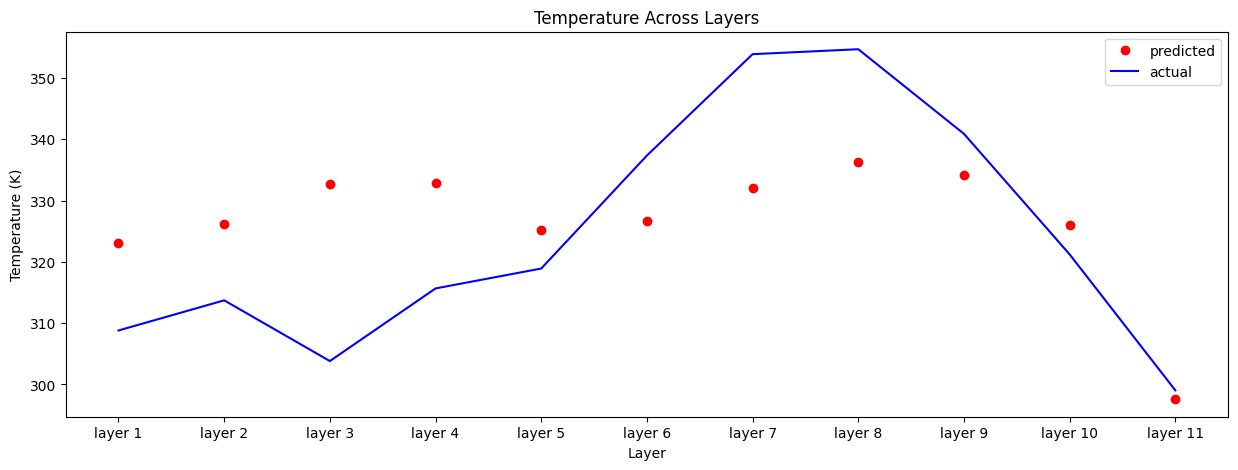

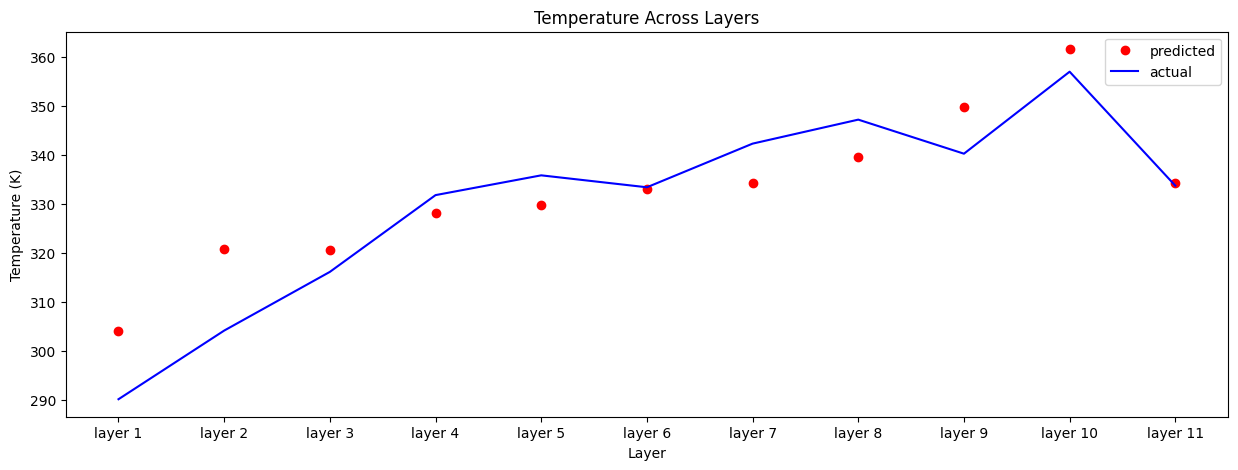

In [613]:


for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual)

In [614]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write(f'------------------------\n| {now.strftime("%m/%d/%Y, %H:%M:%S")} |\n------------------------\n\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'layer {i} loss: {test_losses[i-1]}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'{key}: {args[key]}\n'

    f.write(f'Losses:\n--------\n{loss_str}\nArgs:\n-------\n{arg_str}\n\n')